In [1]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Manual np_utils functionalities
import numpy as np

def np_utils(y, num_classes=None):
    y = np.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes))
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

In [3]:
'''crema_directory_list = os.listdir(Crema)
Crema = "/kaggle/input/cremad/AudioWAV/"
file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()'''

'crema_directory_list = os.listdir(Crema)\nCrema = "/kaggle/input/cremad/AudioWAV/"\nfile_emotion = []\nfile_path = []\n\nfor file in crema_directory_list:\n    # storing file paths\n    file_path.append(Crema + file)\n    # storing file emotions\n    part=file.split(\'_\')\n    if part[2] == \'SAD\':\n        file_emotion.append(\'sad\')\n    elif part[2] == \'ANG\':\n        file_emotion.append(\'angry\')\n    elif part[2] == \'DIS\':\n        file_emotion.append(\'disgust\')\n    elif part[2] == \'FEA\':\n        file_emotion.append(\'fear\')\n    elif part[2] == \'HAP\':\n        file_emotion.append(\'happy\')\n    elif part[2] == \'NEU\':\n        file_emotion.append(\'neutral\')\n    else:\n        file_emotion.append(\'Unknown\')\n\nemotion_df = pd.DataFrame(file_emotion, columns=[\'Emotions\'])\n\npath_df = pd.DataFrame(file_path, columns=[\'Path\'])\nCrema_df = pd.concat([emotion_df, path_df], axis=1)\nCrema_df.head()'

In [4]:
Ravdess_df = pd.read_csv("/kaggle/input/dataframes/ravdess_df.csv")
Ravdess_df.head()

,Emotions,Path
0,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
1,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
3,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
4,fear,/kaggle/input/ravdess-emotional-speech-audio/a...


In [5]:
audio_file = '/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-01-01-01-01-01.wav' # Replace with actual file paths

print("Sampling Rate : "+ str(librosa.get_samplerate(audio_file))+"Hz")
print("Duration : "+ str(librosa.get_duration(filename=audio_file))+"s")

signal, sampling_rate = librosa.load(audio_file, sr=44100, mono=False)
print("Shape of Initial Data : "+ str(signal.shape))

Sampling Rate : 48000Hz
Duration : 3.3032916666666665s
Shape of Initial Data : (145676,)


In [6]:
print(signal.shape)
audio_mono = librosa.to_mono(signal)
print(audio_mono.shape)

(145676,)
(145676,)


In [7]:
print("Original Sampling Rate : "+str(sampling_rate)+" Hz")
signal_44k = librosa.resample(audio_mono, orig_sr=sampling_rate, target_sr=44100)
#signal_88k = librosa.resample(audio_mono, orig_sr=sampling_rate, target_sr=88200)
print(signal_44k.shape)
#print(signal_88k.shape)

Original Sampling Rate : 44100 Hz
(145676,)


# EDA

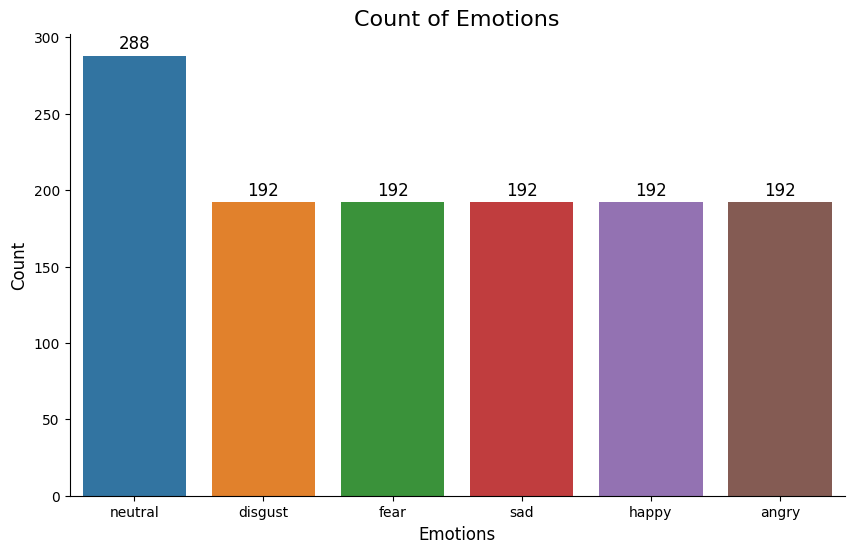

In [9]:
plt.figure(figsize=(10, 6))
plt.title('Count of Emotions', size=16)
count_plot = sns.countplot(data=Ravdess_df, x='Emotions')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)

# Annotate the bars with the count values
for p in count_plot.patches:
    count = int(p.get_height())
    count_plot.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                        textcoords='offset points')

plt.show()

In [10]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.show()

#  Audio Augmentation

In [11]:
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    D = librosa.stft(data)
    # Stretch using phase vocoder
    stretched = librosa.phase_vocoder(D, rate=rate)
    # Inverse STFT to get the stretched audio signal
    stretched_audio = librosa.istft(stretched)
    return stretched_audio

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    data_stretched = stretch(data, rate=pitch_factor)
    return data_stretched

# Taking any example and checking for techniques
path = np.array(Ravdess_df.Path)[1]
data, sample_rate = librosa.load(path)

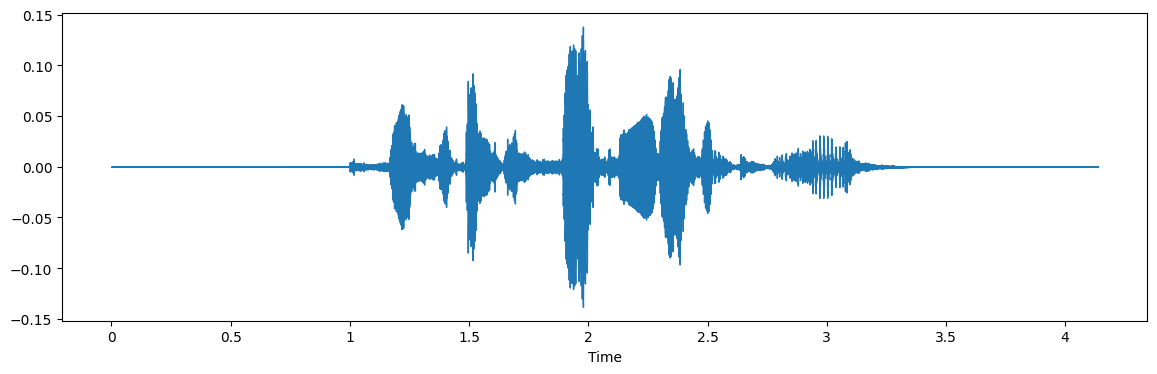

In [12]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

# Feature Extraction

In [13]:
def extract_features(data, sample_rate):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))  # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))  # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))  # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))  # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))  # stacking horizontally

    return result

def get_features(path, emotion=None):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data, sample_rate)
    result = [(res1, emotion)]

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result.append((res2, emotion))

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch, sample_rate)
    result.append((res3, emotion))

    shifted_data = shift(data)
    res4 = extract_features(shifted_data, sample_rate)
    result.append((res4, emotion))

    return result

In [14]:
from joblib import Parallel, delayed

In [15]:
def process_file(path, emotion):
    features = get_features(path, emotion)
    return features

# Use joblib to parallelize the process
result = Parallel(n_jobs=-1)(delayed(process_file)(path, emotion) for path, emotion in zip(Ravdess_df.Path, Ravdess_df.Emotions))

# Flatten the results and separate X and Y
X, Y = zip(*[item for sublist in result for item in sublist])

# Convert to numpy arrays
X = np.array(X)
Y = np.array(Y)

In [17]:
len(X), len(Y), Ravdess_df.Path.shape

(4992, 4992, (1248,))

In [18]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.256113,0.621621,0.580278,0.598515,0.628296,0.598014,0.597272,0.650352,0.698635,0.681863,...,0.000018,0.000016,0.000013,0.000012,0.000007,0.000008,0.000008,0.000005,5.802854e-07,neutral
1,0.332004,0.705712,0.710101,0.753336,0.768450,0.751015,0.675261,0.703234,0.741680,0.731844,...,0.000274,0.000275,0.000274,0.000269,0.000261,0.000260,0.000258,0.000278,2.637291e-04,neutral
2,0.171574,0.602078,0.567036,0.578853,0.599983,0.558323,0.566773,0.627074,0.704996,0.669555,...,0.000004,0.000004,0.000002,0.000003,0.000001,0.000002,0.000002,0.000001,1.212694e-07,neutral
3,0.257030,0.618878,0.601810,0.578307,0.638600,0.596299,0.598322,0.626241,0.692544,0.697749,...,0.000018,0.000016,0.000013,0.000012,0.000007,0.000008,0.000008,0.000005,5.802817e-07,neutral
4,0.180632,0.621834,0.632666,0.567364,0.558964,0.592169,0.638070,0.635625,0.634870,0.589902,...,0.000083,0.000103,0.000160,0.000099,0.000060,0.000060,0.000056,0.000033,3.975708e-06,disgust


In [19]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from collections import Counter
from sklearn.decomposition import PCA
import pandas as pd

# Assuming X and Y are your features and labels respectively
# Check the unique classes and their counts in Y
unique_classes = np.unique(Y)
print("Unique classes in Y:", unique_classes)
print("Number of unique classes:", len(unique_classes))

# Check the distribution of classes
class_distribution = Counter(Y)
print("Class distribution:", class_distribution)

# Proceed with data splitting
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)

# Verify the unique classes in the train and test splits
print("Unique classes in y_train:", np.unique(y_train))
print("Unique classes in y_test:", np.unique(y_test))

# Scaling data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Making data compatible with model
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

# One-hot encoding the target data
encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test = encoder.transform(y_test.reshape(-1, 1)).toarray()

print("Shape of y_train after one-hot encoding:", y_train.shape)
print("Shape of y_test after one-hot encoding:", y_test.shape)

# Check the number of classes
num_classes = y_train.shape[1]
print("Number of classes:", num_classes)

# Save features to a CSV file
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

# Apply PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=0.95)  # Choose the number of components to explain 95% of the variance
X_pca = pca.fit_transform(X_scaled)

# Check the number of components after PCA
print("Number of components after PCA:", X_pca.shape[1])

# Split the data into train and test sets
x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, Y, test_size=0.2, random_state=128)

Unique classes in Y: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']
Number of unique classes: 6
Class distribution: Counter({'neutral': 1152, 'disgust': 768, 'fear': 768, 'sad': 768, 'happy': 768, 'angry': 768})
Unique classes in y_train: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']
Unique classes in y_test: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']
Shape of y_train after one-hot encoding: (3744, 6)
Shape of y_test after one-hot encoding: (1248, 6)
Number of classes: 6
Number of components after PCA: 56


In [20]:
print("Shape of y_train_pca:", y_train_pca.shape)

Shape of y_train_pca: (3993,)


In [21]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# Create the LabelEncoder instance
label_encoder = LabelEncoder()

# Fit and transform the training labels
y_train_encoded = label_encoder.fit_transform(y_train_pca)

# Transform the test labels
y_test_encoded = label_encoder.transform(y_test_pca)

# Get the number of classes
num_classes = len(label_encoder.classes_)

# Convert labels to one-hot encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train_encoded, num_classes)
y_test_one_hot = tf.keras.utils.to_categorical(y_test_encoded, num_classes)

In [22]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_pca, y_train_encoded)
y_train_resampled_one_hot = tf.keras.utils.to_categorical(y_train_resampled, num_classes)

# Reshape data for LSTM input
x_train_resampled_reshaped = np.reshape(x_train_resampled, (x_train_resampled.shape[0], 1, x_train_resampled.shape[1]))
x_test_pca_reshaped = np.reshape(x_test_pca, (x_test_pca.shape[0], 1, x_test_pca.shape[1]))


In [39]:
#from tensorflow.keras.callbacks import EarlyStopping

# Model 1 <-> Bi-LSTM

In [24]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
# Create the model
model1 = Sequential()
model1.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(1, x_train_pca.shape[1])))
model1.add(Dropout(0.2))
model1.add(Bidirectional(LSTM(64)))
model1.add(Dropout(0.2))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(num_classes, activation='softmax'))

# Compile the model
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
# Train the model
history1 = model1.fit(x_train_resampled_reshaped, y_train_resampled_one_hot,
                    validation_data=(x_test_pca_reshaped, y_test_one_hot),
                    epochs=200, batch_size=32)

# Evaluate the model
loss, accuracy = model1.evaluate(x_test_pca_reshaped, y_test_one_hot)
print("Test Accuracy:", accuracy)

# Generate predictions
y_pred_prob = model1.predict(x_test_pca_reshaped)
y_pred = np.argmax(y_pred_prob, axis=1)

# Generate classification report
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

# Print model summary
print(model1.summary())

Epoch 1/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.3525 - loss: 1.5733 - val_accuracy: 0.5275 - val_loss: 1.1837
Epoch 2/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5677 - loss: 1.0904 - val_accuracy: 0.6096 - val_loss: 1.0088
Epoch 3/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6554 - loss: 0.8919 - val_accuracy: 0.6507 - val_loss: 0.8815
Epoch 4/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7124 - loss: 0.7652 - val_accuracy: 0.7077 - val_loss: 0.7634
Epoch 5/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7598 - loss: 0.6244 - val_accuracy: 0.7347 - val_loss: 0.7103
Epoch 6/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7924 - loss: 0.5693 - val_accuracy: 0.7588 - val_loss: 0.6408
Epoch 7/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8110 - loss: 0.4917 - val_accuracy: 0.7798 - val_loss: 0.5885
Epoch 8/200
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8248 - loss: 0.4692 - val_acc

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 1, 256)         │       189,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,113,236 (4.25 MB)

 Trainable params: 371,078 (1.42 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 742,158 (2.83 MB)

None


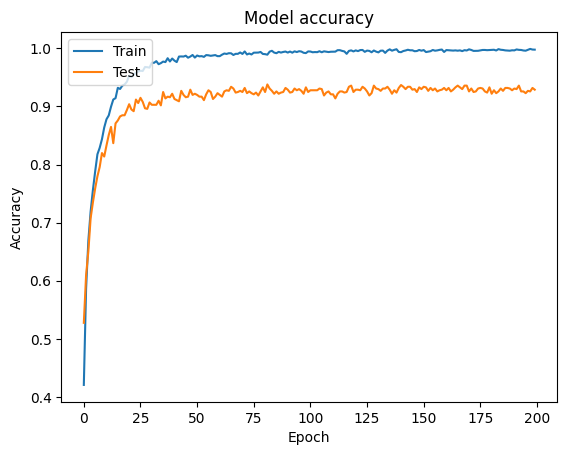

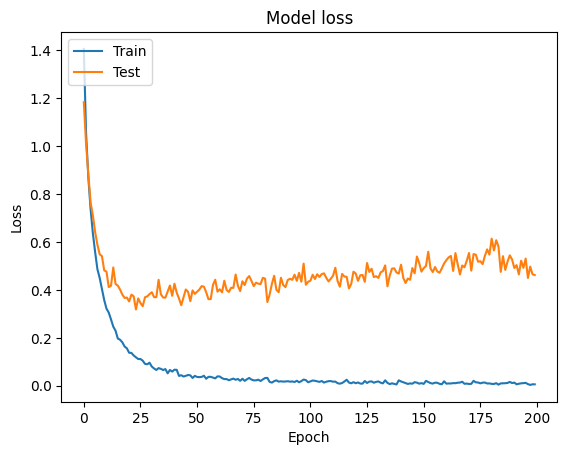

In [25]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


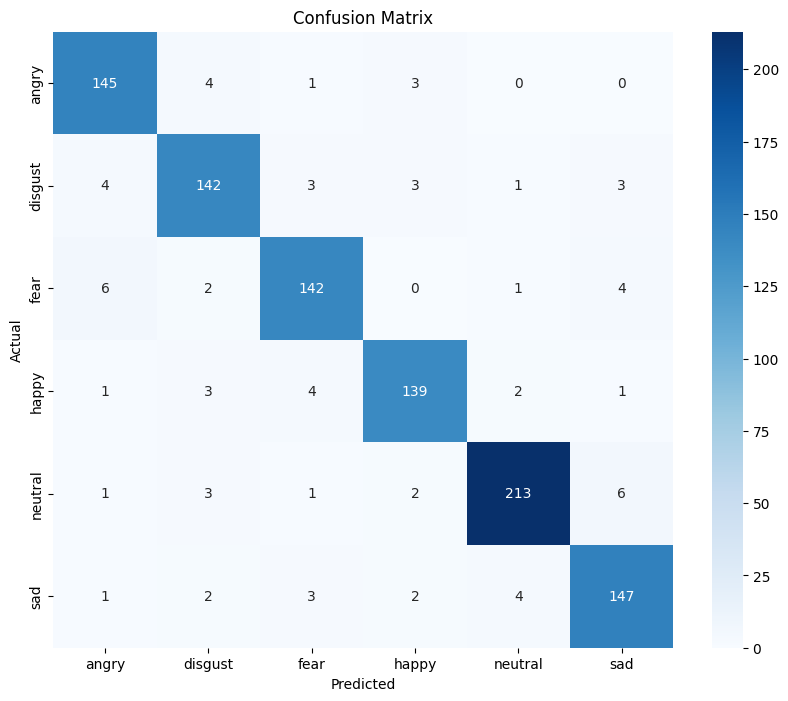

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict probabilities for each class
y_pred_probs = model1.predict(x_test_pca_reshaped)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(np.argmax(y_test_one_hot, axis=1), y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

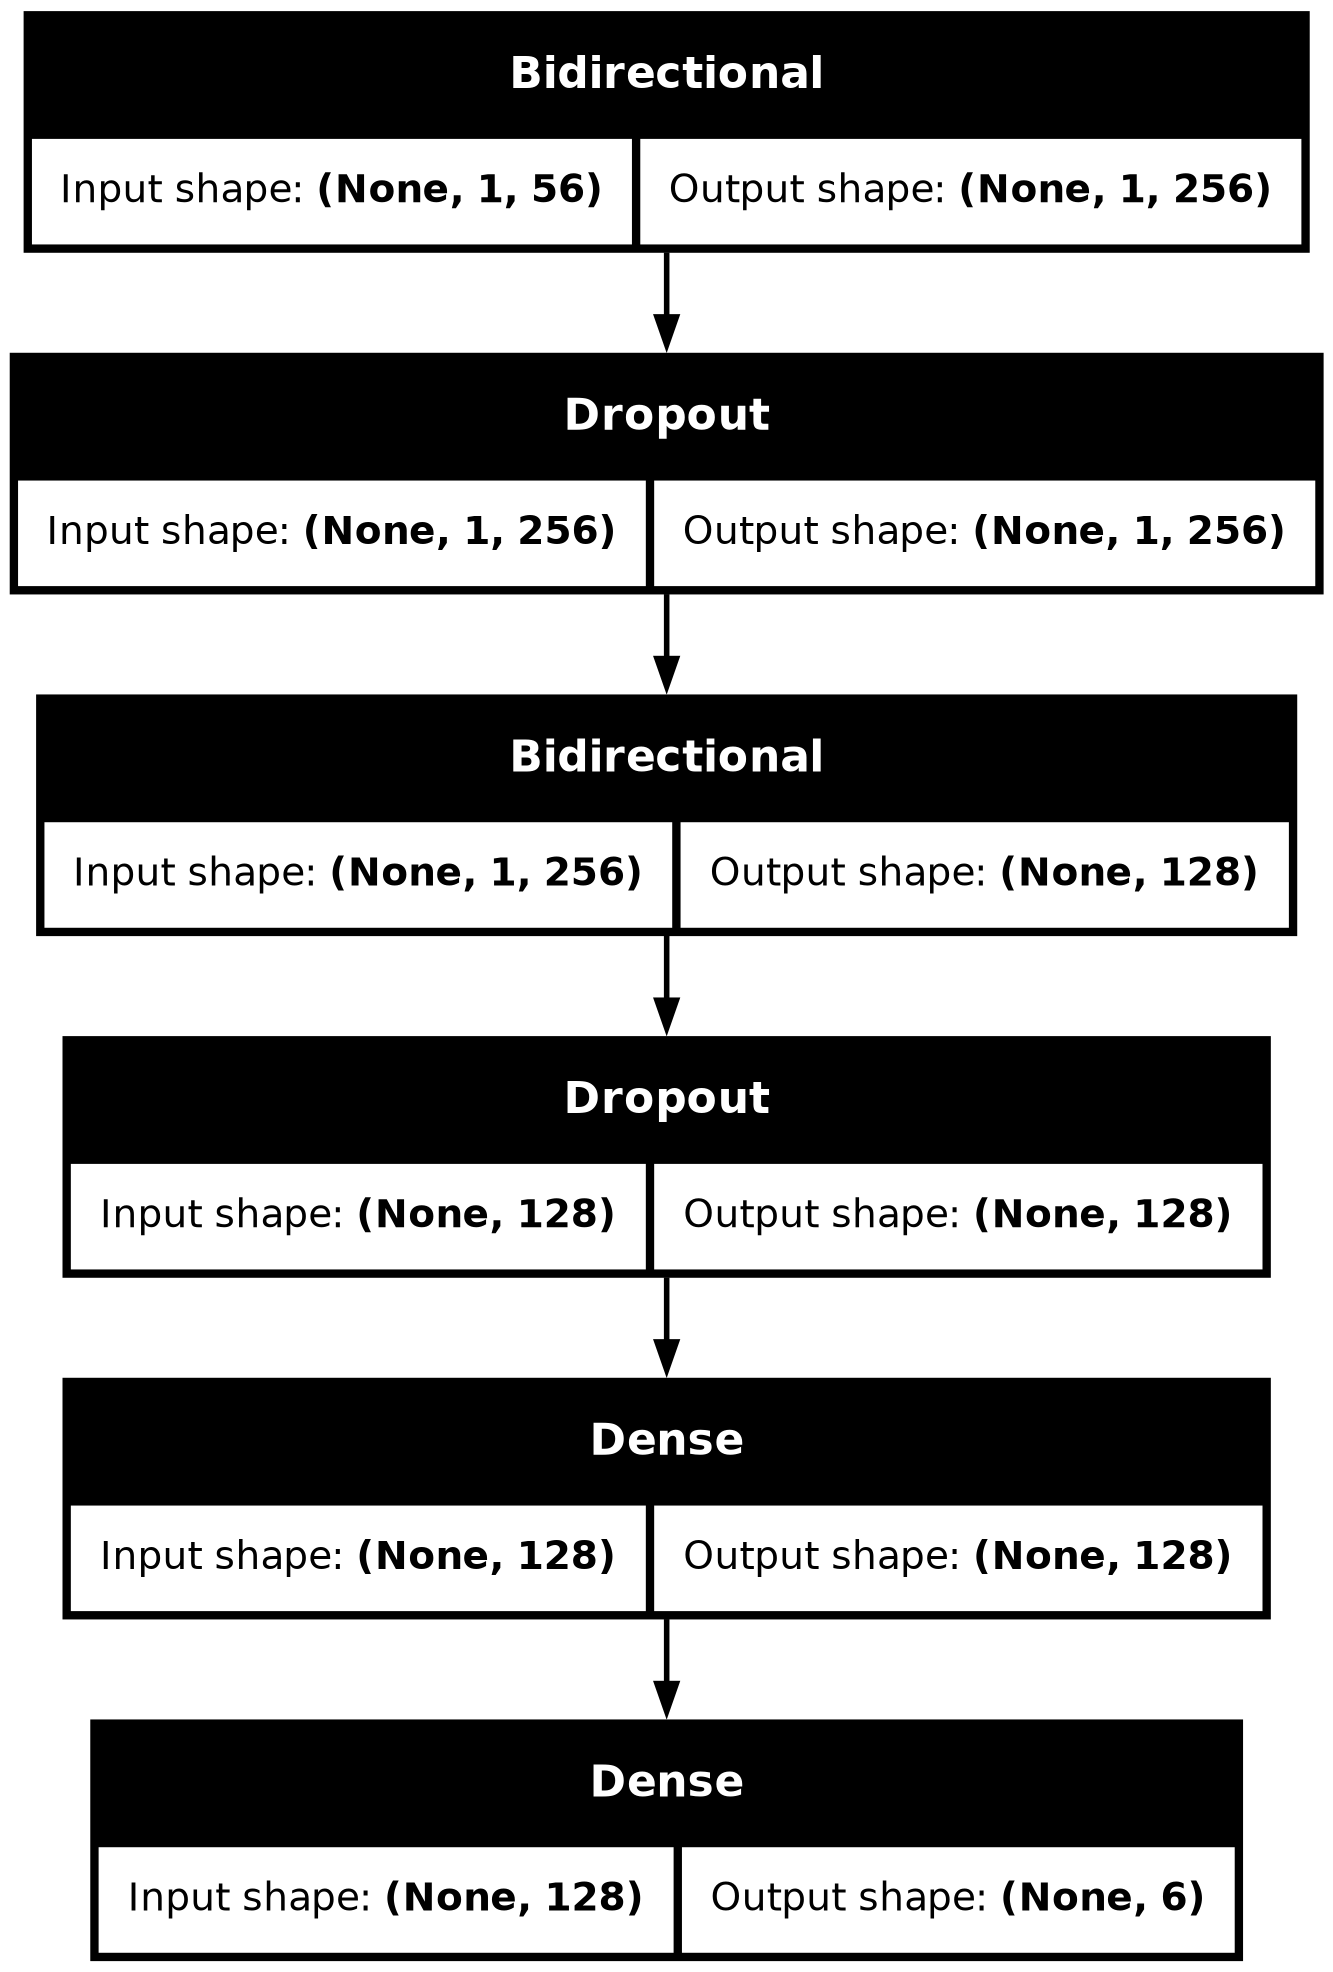

In [27]:
from tensorflow.keras.utils import plot_model

# Visualize the model architecture
plot_model(model1, to_file='model_1_architecture.png', show_shapes=True)

Shape of x_train_pca_reshaped: (25350, 74, 1)
